<a href="https://colab.research.google.com/github/npasuparthi/nagendra-AI_ML/blob/master/Face_mask_Prediction_Project_Nagendra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
data = np.load('/content/drive/MyDrive/Advanced_CV_Project/Dataset- Images.npy',allow_pickle = True )

In [3]:
data.size

818

In [4]:
data.shape

(409, 2)

In [5]:
# look at any sample, note that image width is different across Images
data[50]

array([array([[[ 34,  39,  35],
        [ 32,  37,  33],
        [ 33,  38,  34],
        ...,
        [ 95, 115, 122],
        [ 97, 117, 124],
        [100, 119, 126]],

       [[ 38,  43,  39],
        [ 36,  41,  37],
        [ 36,  41,  37],
        ...,
        [ 99, 119, 126],
        [101, 121, 128],
        [104, 123, 130]],

       [[ 45,  50,  46],
        [ 41,  47,  43],
        [ 40,  45,  41],
        ...,
        [101, 121, 128],
        [103, 123, 130],
        [104, 123, 130]],

       ...,

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 37,  42,  48],
        [ 37,  42,  48]],

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 36,  41,  47],
        [ 36,  41,  47]],

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 35,  40,  46],
        [ 35,  40

In [6]:
# Resize to 224x224 as standard size for all Images
IMAGE_WIDTH = 224   
IMAGE_HEIGHT = 224 

In [7]:
#
#This is an Image Segmentation Problem. Train image is the original image (resized)
#and mask represents the pixels where there is a face
#
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0] # represents each image
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1 #sets the rectangular region comprising teh face to 1

In [8]:
print(X_train.shape)
print(masks.shape)


(409, 224, 224, 3)
(409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


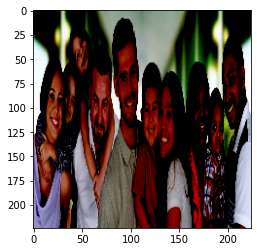

In [9]:
# Image Visualization
from matplotlib import pyplot
n = 324
pyplot.imshow(X_train[n])

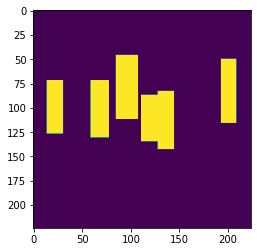

In [10]:
# Image mask visualization
pyplot.imshow(masks[n])


In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
     #### code added below ####
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #### code added below ####

    # Since mask size is 224 (same as input), we need to concatenate it back all 6 layers, i.e layers of sizes 7,14,28,56,112 & 224, bottom onwards
    block1 = model.get_layer("input_1").output         #224
    block2 = model.get_layer("conv_pw_1_relu").output  #112
    block3 = model.get_layer("conv_pw_3_relu").output  #56
    block4 = model.get_layer("conv_pw_5_relu").output  #28
    block5 = model.get_layer("conv_pw_11_relu").output #14
    block6 = model.get_layer("conv_pw_13_relu").output #7

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
 
    # Add new top layer which is an sigmoid activation layer that gives 1 or 0 depending on inside/outside the face
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
 
    return Model(inputs=model.input, outputs=x)

In [12]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=True)

# Print summary
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [23]:
import tensorflow as tf

In [24]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [25]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [26]:
from tensorflow.python.keras import losses

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [28]:
#from tensorflow.keras.losses import binary_crossentropy
#from tensorflow.keras.backend import log, epsilon
#def loss2(y_true, y_pred):
#    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [29]:

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#dice_coefficient is the metric
model.compile(loss=bce_dice_loss, optimizer=optimizer, metrics=[dice_coeff])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="bce_dice_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="bce_dice_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="bce_dice_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [31]:
model.fit(
    x=X_train, y=masks, batch_size=1, epochs=10, 
    callbacks=[checkpoint, reduce_lr, stop], use_multiprocessing=True)

Epoch 1/10
409/409 [==============================] - 65s 128ms/step - loss: 0.9084 - dice_coeff: 0.4310 - lr: 1.0000e-04
Epoch 2/10
409/409 [==============================] - 54s 131ms/step - loss: 0.5871 - dice_coeff: 0.6114 - lr: 1.0000e-04
Epoch 3/10
409/409 [==============================] - 54s 131ms/step - loss: 0.4766 - dice_coeff: 0.6760 - lr: 1.0000e-04
Epoch 4/10
409/409 [==============================] - 53s 130ms/step - loss: 0.4378 - dice_coeff: 0.7007 - lr: 1.0000e-04
Epoch 5/10
409/409 [==============================] - 53s 131ms/step - loss: 0.4093 - dice_coeff: 0.7188 - lr: 1.0000e-04
Epoch 6/10
409/409 [==============================] - 53s 131ms/step - loss: 0.3854 - dice_coeff: 0.7346 - lr: 1.0000e-04
Epoch 7/10
409/409 [==============================] - 54s 131ms/step - loss: 0.3714 - dice_coeff: 0.7459 - lr: 1.0000e-04
Epoch 8/10
409/409 [==============================] - 54s 131ms/step - loss: 0.3570 - dice_coeff: 0.7554 - lr: 1.0000e-04
Epoch 9/10
409/409 [====

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Sample Image: 324


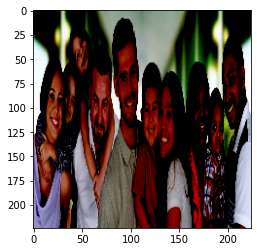


 Given Mask: 324


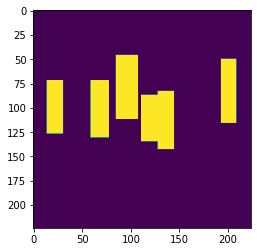


 Predicted Mask: 324


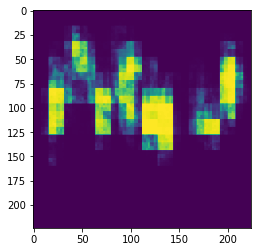

In [32]:
n = 324
sample_image = X_train[n]

#### Code below ####
print("\n Sample Image: "+ str(n)) # Sample image
pyplot.imshow(sample_image) 
pyplot.show()

print("\n Given Mask: "+ str(n)) # Given Mask
pyplot.imshow(masks[n])
pyplot.show()

print("\n Predicted Mask: "+ str(n)) # Predicted Mask
a=model.predict(sample_image.reshape(1,224,224,3))
pyplot.imshow(a.reshape(224,224)) 
pyplot.show()

In [36]:

from PIL import Image
from numpy import asarray
# load the image
image = Image.open('/content/drive/MyDrive/Advanced_CV_Project/Prediction_Image.jpeg')
# convert image to numpy array
sample_image = asarray(image)

In [39]:
sample_image.shape

(500, 500, 3)

In [41]:
sample_image = cv2.resize(sample_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)

In [42]:
sample_image.shape

(224, 224, 3)

In [44]:
sample_image_processed = preprocess_input(np.array(sample_image, dtype=np.float32))


 Sample Image: 324


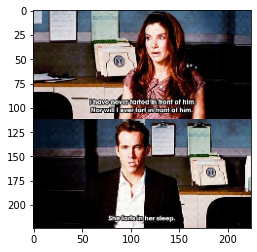


 Predicted Mask: 324


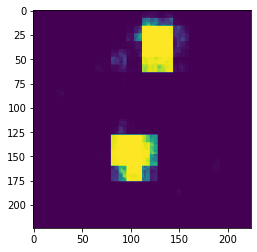

In [45]:
#### Code below ####
print("\n Sample Image: "+ str(n)) # Sample image
pyplot.imshow(sample_image) 
pyplot.show()


print("\n Predicted Mask: "+ str(n)) # Predicted Mask
a=model.predict(sample_image_processed.reshape(1,224,224,3))
pyplot.imshow(a.reshape(224,224)) 
pyplot.show()